In [1]:
from google.colab import drive
drive.mount('/content/drive')
#

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import librosa

In [4]:
path = []
labels = []
for dirname ,_, filenames in os.walk('/content/drive/MyDrive/dataverse_files'):
  for filename in filenames:
    path.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split('_')[0]
    labels.append(label.lower())

In [5]:
df= pd.DataFrame()
df['speech']= path
df['label']= labels
df.head()

,speech,label
0,/content/drive/MyDrive/dataverse_files/YAF_too...,fear.wav
1,/content/drive/MyDrive/dataverse_files/OAF_hal...,ps.wav
2,/content/drive/MyDrive/dataverse_files/YAF_thu...,fear.wav
3,/content/drive/MyDrive/dataverse_files/YAF_tea...,fear.wav
4,/content/drive/MyDrive/dataverse_files/YAF_ton...,fear.wav


In [6]:
df.shape

(2800, 2)

<Axes: xlabel='count', ylabel='label'>

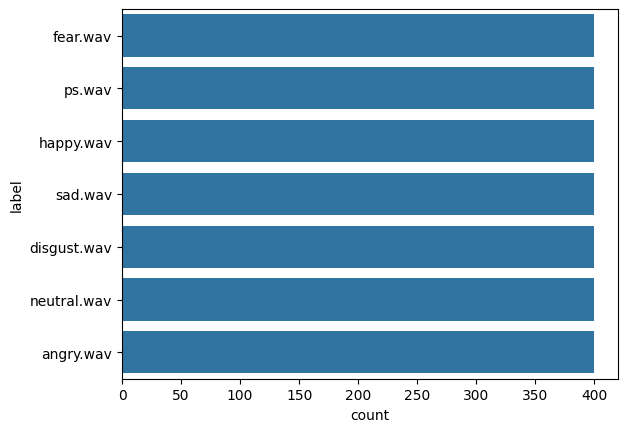

In [7]:
import seaborn as sns
sns.countplot(df['label'])

In [8]:
def extract(filename):
  y, sr = librosa.load(filename, duration=3, offset=0.5)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr= sr, n_mfcc =40),axis= 1)
  return mfcc

In [9]:
a = extract(df['speech'][0])
a

array([-3.31543274e+02,  4.39122086e+01,  1.17556408e-01,  8.83139229e+00,
       -2.27612190e+01,  4.79101849e+00,  5.09730768e+00, -1.43355503e+01,
       -8.73493195e+00,  3.33219624e+00, -1.82146225e+01,  7.07624197e+00,
       -4.65224361e+00,  9.92616594e-01,  2.93783760e+00, -5.43113661e+00,
       -3.50047708e+00,  1.36481466e+01, -5.95185935e-01,  1.65688171e+01,
        1.28260984e+01,  7.33329630e+00,  3.61947274e+00,  1.02239485e+01,
        7.05651140e+00,  1.16573896e+01, -2.98225790e-01,  9.99548256e-01,
       -4.72552633e+00,  1.56845045e+00, -5.98110437e+00,  1.93510562e-01,
       -1.14829416e+01, -5.57732821e+00, -3.73556304e+00,  4.38053894e+00,
        1.82071352e+00,  5.34840679e+00,  3.53675175e+00,  4.39409161e+00],
      dtype=float32)

In [10]:
a_mfcc= df['speech'].apply(lambda x: extract(x))

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc= OneHotEncoder()
y= enc.fit_transform(df[['label']])

[Text(0.5, 1.0, 'fear.wav')]

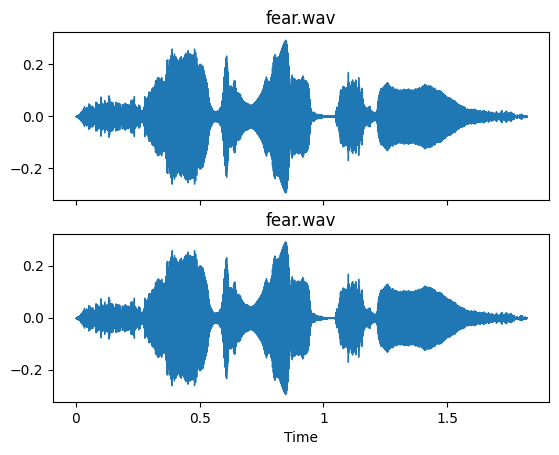

In [12]:
x_1, fs = librosa.load(df['speech'][0])
# And a second version, slightly faster.
x_2, fs = librosa.load(df['speech'][0])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.waveshow(x_1, sr=fs, ax=ax[0])
ax[0].set(title=df['label'][0])
ax[0].label_outer()

librosa.display.waveshow(x_2, sr=fs, ax=ax[1])
ax[1].set(title=df['label'][0])

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model= Sequential([
    LSTM(256, return_sequences= False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation= 'relu'),
    Dropout(0.1),
    Dense(64, activation= 'relu'),
    Dropout(0.1),
    Dense(7, activation= 'softmax')

])

model.compile(loss= 'categorical_crossentropy' , optimizer = 'adam', metrics= ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [18]:
x=[x for x in a_mfcc]
x=np.array(x)
x = np.expand_dims(x, -1)
x.shape

(2800, 40, 1)

In [21]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [22]:
enc.get_feature_names_out()

array(['label_angry.wav', 'label_disgust.wav', 'label_fear.wav',
       'label_happy.wav', 'label_neutral.wav', 'label_ps.wav',
       'label_sad.wav'], dtype=object)

In [23]:
y = y.toarray()

In [24]:
history = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
35/35 [==============================] - 10s 196ms/step - loss: 1.0512 - accuracy: 0.5978 - val_loss: 1.3403 - val_accuracy: 0.4143
Epoch 2/5
35/35 [==============================] - 7s 206ms/step - loss: 0.3225 - accuracy: 0.9018 - val_loss: 1.6860 - val_accuracy: 0.4321
Epoch 3/5
35/35 [==============================] - 6s 161ms/step - loss: 0.1563 - accuracy: 0.9487 - val_loss: 0.8344 - val_accuracy: 0.7429
Epoch 4/5
35/35 [==============================] - 8s 226ms/step - loss: 0.1051 - accuracy: 0.9656 - val_loss: 0.8559 - val_accuracy: 0.7696
Epoch 5/5
35/35 [==============================] - 6s 167ms/step - loss: 0.1031 - accuracy: 0.9688 - val_loss: 1.1076 - val_accuracy: 0.6768
